# Training a neural network model to generate a document deformation mesh in an image.

Author: Maciej Kubiś

Date: 2025-03-24

The notebook will allow training of various AI models created using pytorch or tensorflow. Two architectures will be trained: FCN, U-Net

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import importlib.util
import sys

sys.path.append("../src") 

spec = importlib.util.spec_from_file_location("data_generator", "../src/data_generator.py")
data_generator = importlib.util.module_from_spec(spec)
spec.loader.exec_module(data_generator)

spec = importlib.util.spec_from_file_location("neuralnet_handler", "../src/neuralnet_handler.py")
neuralnet_handler = importlib.util.module_from_spec(spec)
spec.loader.exec_module(neuralnet_handler)

## Configuration

It is possible to set device where will be handle neural network. Image gnerator require file with any text to produce random content of documents.

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
generator = data_generator.DocumentImageGenerator("../src/assets/text.txt")
# generator.set_seed(42)

nn_handler = neuralnet_handler.NeuralNetHandler(None, generator, device, 5, 0.001, 5)

Using device: cpu
Model is None. Please provide a valid model using set_model() method.


## U-Net using PyTorch

In [3]:
class UNetTorchModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super(UNetTorchModel, self).__init__()
        # Encoder part
        self.encoder = nn.Sequential(
            nn.Conv2d(1, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(hidden_dim, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(hidden_dim*2, hidden_dim*4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*4),
            nn.ReLU(inplace=True)
        )
        
        # Decoder part
        self.decoder = nn.Sequential(
            nn.Conv2d(hidden_dim*4, hidden_dim*2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim*2),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(hidden_dim*2, hidden_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            
            nn.Conv2d(hidden_dim, 2, kernel_size=3, padding=1),
        )
        
    def forward(self, x):
        # Get input dimensions
        batch_size, channels, height, width = x.shape
        
        # Pass through encoder
        features = self.encoder(x)
        
        # Pass through decoder
        offsets = self.decoder(features)
        
        # Resize to input dimensions if necessary
        if offsets.shape[2:] != (height, width):
            offsets = nn.functional.interpolate(offsets, size=(height, width), mode='bilinear', align_corners=True)
        
        return offsets
    
model = UNetTorchModel()

nn_handler.set_model(model, "unet_torch_model") 

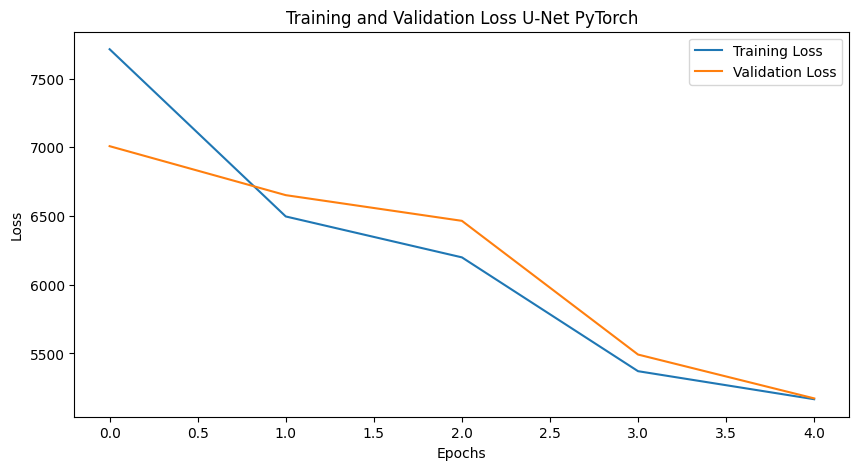

In [4]:
nn_handler.train()

# Clear the output before plotting
from IPython.display import clear_output
clear_output(wait=True)

# Plot training progress
plt.figure(figsize=(10, 5))
plt.plot(nn_handler.get_train_losses(), label='Training Loss')
plt.plot(nn_handler.get_val_losses(), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss U-Net PyTorch')
plt.legend()
plt.show()

In [5]:
nn_handler.save_model("../models/unet_torch_model.pth")

Model saved to ../models/unet_torch_model.pth
